In [1]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model, preprocessing
#import statsmodels.formula.api as smf
import statsmodels.api as sm
import directional # from https://github.com/calben/directionalstatspy/
from IPython.display import display
import warnings

In [2]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files])
df_imported.index = pd.DatetimeIndex(df_imported.index, freq='H')
grouped = df_imported.groupby(level=0)
df_imported = grouped.last()
df_imported.count()

$                           168
dateStamp                    28
dew_point                   168
modelCode                    28
modelRun                     28
periodSchedule               28
pressure                    168
screen_relative_humidity    168
sea_temperature             168
surf_max                     28
surf_min                     28
swell_direction1             28
swell_direction2             28
swell_direction3             28
swell_height1                28
swell_height2                28
swell_height3                28
swell_period1                28
swell_period2                28
swell_period3                28
temperature                 168
wave_height                 168
wave_period                 168
wind_direction              168
wind_speed                  168
dtype: int64

In [3]:
def plot_datetime_series(series, title, xlabel='Time', ylabel='', label=['b-', 'g-', 'r-', 'y-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        if type(s.index) is not pd.tseries.index.DatetimeIndex:
            dates = matplotlib.dates.date2num([dateutil.parser.parse(dt) for dt in s.index])
        else:
            dates = s.index
        plt.plot_date(
            dates,
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()

available target values: 28


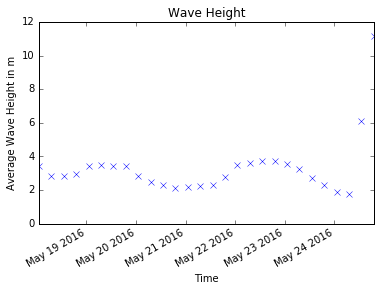

target values after interpolation: 163


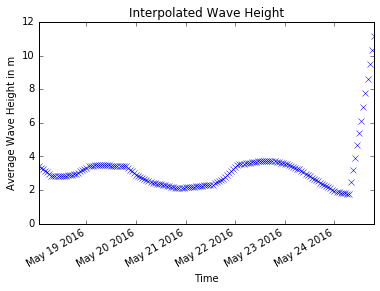

In [4]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', 'bx')
# fill NAs with linearly interpolated data where explanatory data is present
s_target = s_target.loc[df_imported['wind_speed'].notnull()].interpolate()
#---respective data removed---- there's a big gap which we shouldn't interpolate
#s_target['2016-05-16 14:00:00':'2016-05-18 00:00:00'] = None
print('target values after interpolation:', s_target.count())  
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', 'bx')

In [5]:
#directional.angle.radian_matrix_to_sin_cos_matrix(pd.DataFrame(df_explanatory['wind_direction']))?circular_example.drop
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))
?math.sin

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees--SIN,degrees--COS
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


In [81]:
# sorted out at this point: 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature'
df_explanatory = df_imported[['wind_direction', 'wind_speed', 'wave_height', 'wave_period', 'pressure']]
df_explanatory = df_explanatory.dropna()
df_explanatory
display(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('becomes')
display(df_explanatory['wind_direction'].head())
print('becomes')
df_explanatory = degrees_to_sin_cos(df_explanatory, 'wind_direction')
display(df_explanatory[['wind_direction--SIN','wind_direction--COS']].head())

2016-05-17 20:00:00    WSW
2016-05-17 21:00:00    WSW
2016-05-17 22:00:00    WSW
2016-05-17 23:00:00      W
2016-05-18 00:00:00      W
Freq: H, Name: wind_direction, dtype: object

becomes


2016-05-17 20:00:00    247.5
2016-05-17 21:00:00    247.5
2016-05-17 22:00:00    247.5
2016-05-17 23:00:00    270.0
2016-05-18 00:00:00    270.0
Freq: H, Name: wind_direction, dtype: float64

becomes


,wind_direction--SIN,wind_direction--COS
2016-05-17 20:00:00,-0.92388,-3.826834e-01
2016-05-17 21:00:00,-0.92388,-3.826834e-01
2016-05-17 22:00:00,-0.92388,-3.826834e-01
2016-05-17 23:00:00,-1.00000,-1.836970e-16
2016-05-18 00:00:00,-1.00000,-1.836970e-16


In [7]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
int64,wind_speed
float64,sea_temperature
float64,wave_height
float64,wave_period
int64,pressure
float64,wind_direction--SIN
float64,wind_direction--COS


In [8]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_speed             163
sea_temperature        163
wave_height            163
wave_period            163
pressure               163
wind_direction--SIN    163
wind_direction--COS    163
surf_avg               163
dtype: int64

# Normalization

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_train= df_train.apply(preprocessing.scale)
display(df_train.head())

,wind_speed,sea_temperature,wave_height,wave_period,pressure,wind_direction--SIN,wind_direction--COS,surf_avg
2016-05-18 01:00:00,1.788204,-0.495969,0.380017,-0.697447,-0.329666,-0.681531,1.279265,0.178105
2016-05-18 02:00:00,1.101297,-0.495969,1.228550,0.706058,-0.507598,-0.787782,0.495550,0.109766
2016-05-18 03:00:00,1.101297,-0.495969,1.058843,0.706058,-0.507598,-0.681531,1.279265,0.041427
2016-05-18 04:00:00,1.330266,-0.495969,2.077082,0.706058,-0.507598,-0.681531,1.279265,-0.026912
2016-05-18 05:00:00,1.101297,-0.495969,1.907375,0.706058,-0.507598,-0.681531,1.279265,-0.095251


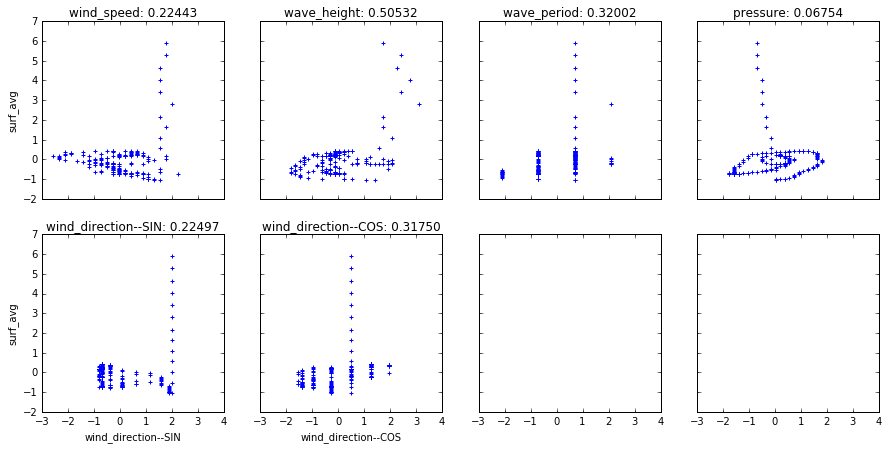

In [82]:
def plot_scatter_correlation(df, target):
    fig, axes = plt.subplots(nrows=math.ceil(len(df.columns)/4), ncols=4, sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    for i,variable in enumerate(df.columns):
        row = 0
        col = i
        if i > 3:
            row = 1
            col = i - 4
        correlation = df[variable].corr(target)
        title = variable + ': ' + "{:.5f}".format(correlation)      
        df_train.plot.scatter(x=variable, y=target_var, marker='+', ax=axes[row,col], title=title)

plot_scatter_correlation(df_train[df_explanatory.columns], df_train[target_var])

# Cross Correlation

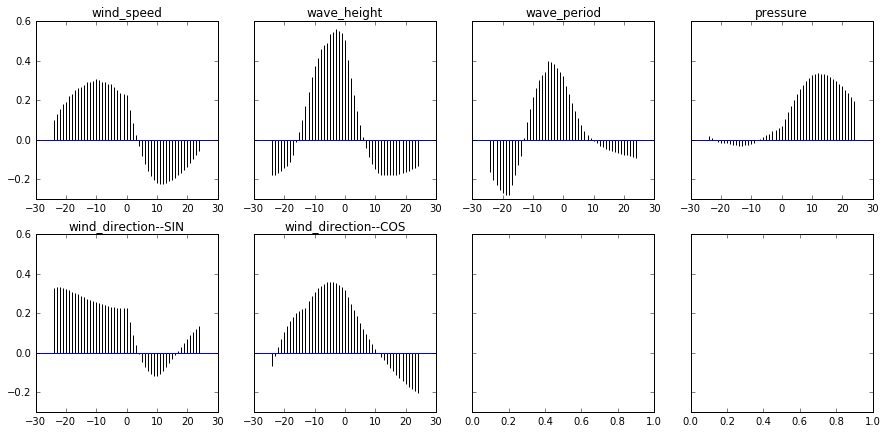

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(7)
for i,var in enumerate(df_explanatory.columns):
    row = 0
    col = i
    if i > 3:
        row = 1
        col = i - 4
    axes[row][col].xcorr(df_train[var], df_train[target_var], maxlags=24)
    axes[row][col].set_title(var)

The highest correlation seems to be at a lag of about -5, but is different for each variable. 
- Wind speed appears to have a very high lag, just like the wind direction.
- Wave height and wave period both have a lag around 5.

In [80]:
lag_compare = pd.DataFrame(
    {'unlagged': [df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
for lag in range(3,7):
    lag_compare['lag '+str(lag)] = [df_train[target_var].shift(-1 * lag).corr(df_train[column]) for column in df_explanatory.columns] 
display(lag_compare)

df_lagged = df_train.copy()
df_lagged[target_var] = df_lagged[target_var].shift(-5)

,unlagged,lag 3,lag 4,lag 5,lag 6
wind_speed,0.224433,0.260023,0.277957,0.296264,0.296920
sea_temperature,-0.121992,-0.225136,-0.276903,-0.267391,-0.280911
wave_height,0.505318,0.588375,0.587433,0.588734,0.556850
wave_period,0.320017,0.383056,0.394975,0.401218,0.349620
pressure,0.067540,0.042775,0.030927,0.021330,0.014160
wind_direction--SIN,0.224970,0.237775,0.243344,0.249678,0.256892
wind_direction--COS,0.317498,0.352510,0.357256,0.358952,0.357256


In [73]:
corr_with_target = pd.DataFrame(
    {'no ewma': [df_lagged[column].corr(df_lagged[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,10):
    corr_with_target['ewma '+str(span)] = pd.Series([ pd.ewma(df_lagged[column], span=span).corr(df_lagged[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
corr_with_target
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,no ewma,ewma 2,ewma 3,ewma 4,ewma 5,ewma 6,ewma 7,ewma 8,ewma 9
wind_speed,0.277957,0.294825,0.305424,0.314513,0.322807,0.330405,0.337245,0.343219,0.348231
sea_temperature,-0.276903,-0.304496,-0.308748,-0.302372,-0.291440,-0.278786,-0.265728,-0.252854,-0.240399
wave_height,0.587433,0.594345,0.592653,0.586446,0.576537,0.563663,0.548550,0.531842,0.514070
wave_period,0.394975,0.427650,0.434191,0.430756,0.421412,0.408240,0.392708,0.375912,0.358642
pressure,0.030927,0.026608,0.022490,0.018645,0.015216,0.012279,0.009856,0.007945,0.006525
wind_direction--SIN,0.243344,0.248687,0.253903,0.259516,0.265594,0.272099,0.278947,0.286030,0.293242
wind_direction--COS,0.357256,0.366062,0.369110,0.369626,0.368529,0.366214,0.362878,0.358645,0.353631


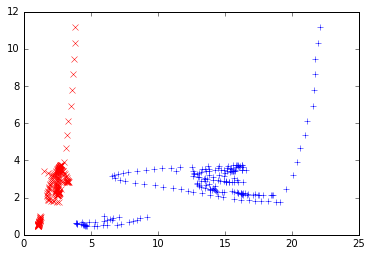

In [137]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], 'b+')
plt.plot(pd.ewma(df_train['wave_height'], span=12), df_train[target_var], 'rx')

In [138]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [-4.99003028  0.87789922  0.02039438 -0.09283538  1.45501816  5.44515644
  1.70354693 -0.12850286  0.6915702   0.78269723]


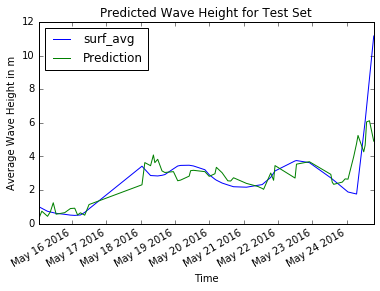

In [139]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m')

coefficients:  [-15.56746034   2.76051981  -0.03034087  -0.15481599  -0.04183947
  16.55285896   1.58227377   0.72140922   1.98505836   2.31836053]
intercept:  -256.579471892


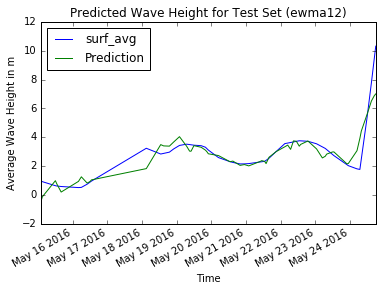

In [140]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_ewma12, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set (ewma12)', 'Time', 'Average Wave Height in m')

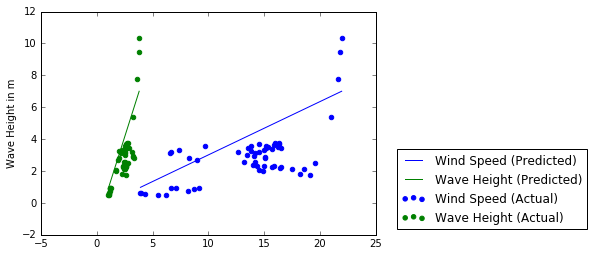

In [141]:
plt.scatter(
    test_set['wind_speed'],
    test_set[target_var],
    color='b'
)
plt.scatter(
    test_set['wave_height'],
    test_set[target_var],
    color='g'
)

predictions_wind_speed = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wind_speed'], name='Prediction').sort_index()
predictions_wave_height = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wave_height'], name='Prediction').sort_index()

plt.plot([test_set['wind_speed'].min(), test_set['wind_speed'].max()], [predictions_wind_speed.iloc[0], predictions_wind_speed.iloc[-1]])
plt.plot([test_set['wave_height'].min(), test_set['wave_height'].max()], [predictions_wave_height.iloc[0], predictions_wave_height.iloc[-1]])
plt.legend(['Wind Speed (Predicted)', 'Wave Height (Predicted)', 'Wind Speed (Actual)', 'Wave Height (Actual)'], bbox_to_anchor=(1.65, 0), loc='lower right')
plt.ylabel('Wave Height in m')

In [142]:
lm = sm.OLS(train_set[target_var], train_set[df_explanatory.columns]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     238.1
Date:                Wed, 25 May 2016   Prob (F-statistic):           1.84e-78
Time:                        15:18:24   Log-Likelihood:                -145.29
No. Observations:                 140   AIC:                             310.6
Df Residuals:                     130   BIC:                             340.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
dew_point                   -5.5594      1.578     -3.523      0.001        -8.682    -2.437
screen_relative_humidity     0.9761      0.270      3.617      0.000         0.442     1.510
pressure                    -0.1065      0.023     -4.727      0.000        -0.151    -0.062
wind_speed                  -0.2005      0.064     -3.134      0.002        -0.327    -0.074
sea_temperature             -0.7451      1.567     -0.475      0.635        -3.845     2.355
temperature                  7.0864      1.872      3.784      0.000         3.382    10.791
wave_height                  1.1509      0.328      3.511      0.001         0.502     1.799
wave_period                  0.9278      0.310      2.990      0.003         0.314     1.542
wind_direction--SIN          2.0420      0.279      7.307      0.000         1.489     2.595
wind_direction--COS          2.6420      0.435      6.078      0.000         1.782     3.502
==============================================================================
Omnibus:                       80.062   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.730
Skew:                           1.900   Prob(JB):                    1.56e-120
Kurtosis:                      11.952   Cond. No.                     4.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R² value indicates the percentage of variance in the data which are explained by the model. This is a good fit, but also may indicate overfit.

In [143]:
print('p value >= 0.5')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.5')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.5
sea_temperature    0.635233
dtype: float64

p value < 0.5
dew_point                   5.899118e-04
screen_relative_humidity    4.259188e-04
pressure                    5.838417e-06
wind_speed                  2.131974e-03
temperature                 2.341197e-04
wave_height                 6.138350e-04
wave_period                 3.336983e-03
wind_direction--SIN         2.461150e-11
wind_direction--COS         1.257875e-08
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.